# Causal Modeling Random Networks

In [1]:
## Load Packages
using Omega
using StatsBase
using Random
using Plots
using Distributions
using PyCall
using DataStructures

Internal error: encountered unexpected error in runtime:
rec_backtrace at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\stackwalk.c:94
record_backtrace at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\task.c:246
jl_throw at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\task.c:577
jl_bounds_error_ints at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\rtutils.c:187
getindex at .\array.jl:731
jfptr_getindex_2272.clone_1 at C:\Users\Devon Kohler\AppData\Local\Julia-1.0.5\lib\julia\sys.dll (unknown line)
jl_apply_generic at /home/Administrator/buildbot/worker/package_win64/build/src/home/Administrator/buildbot/worker/package_win64/build/src\gf.c:2162
replace_code_newstyle! at .\compiler/ssair\legacy.jl:86

## Build Model

Model build using a Gillespie simulation in the probabilistic programming language Omega. Random variable is the choice of reaction at time $t_n$.

In [2]:
te = pyimport("tellurium")
libsbml_draw = pyimport("libsbml_draw")
ant_8_species = te.sbmlToAntimony("..\\artificial_random_signaling_network\\networks\\New_sampleNetwork-1.xml")
print(ant_8_species)

// Created by libAntimony v2.12.0.3
model *doc0()

  // Compartments and Species:
  compartment compartment_;
  species S1 in compartment_, S2 in compartment_, S3 in compartment_, S4 in compartment_;
  species S5 in compartment_, S6 in compartment_, S7 in compartment_, S8 in compartment_;
  species $S_in in compartment_, S_out in compartment_;

  // Reactions:
  r1: $S_in + S6 => S5; kf_J1*S_in*S6 - kr_J1*S5;
  r2: S8 => S_out; S3*(kf_J2*S8/K1_J2 - kr_J2*S_out/K2_J2)/(1 + S8/K1_J2 + S_out/K2_J2);
  r3: S_out => S8; S4*(kf_J3*S_out/K2_J3 - kr_J3*S8/K1_J3)/(1 + S_out/K2_J3 + S8/K1_J3);
  r4: S7 => S4 + S8; kf_J4*S7 - kr_J4*S4*S8;
  r5: S1 => S2; S5*(kf_J5*S1/K1_J5 - kr_J5*S2/K2_J5)/(1 + S1/K1_J5 + S2/K2_J5);
  r6: S7 => S1; S2*(kf_J6*S7/K1_J6 - kr_J6*S1/K2_J6)/(1 + S7/K1_J6 + S1/K2_J6);

  // Species initializations:
  S1 = 0.00130171309746607/compartment_;
  S2 = 0.000109399014890439/compartment_;
  S3 = 0.555397512145426/compartment_;
  S4 = 0.950870153502086/compartment_;
  S5 = 0.736

### Stochastic Petri Net (SPN) parameters

$N = (P, T, Pre, Post, M, h, c)$

$P = (S_{in}, S1, S2, S3, S4, S5, S6, S7, S8, S_{out})^T$

$T = (\text{S_in to S7}, \text{S8 to S_out}, \text{S_out to S8},\text{S3 to S8 and S5}, \text{S7 to S6 and S4}, \text{S4 and S6 to S3})^T$

$Pre = \begin{bmatrix} 1&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&1&0\\
0&0&0&0&0&0&0&0&0&1\\
0&0&0&1&0&0&0&0&0&0\\
0&0&0&0&0&0&0&1&0&0\\
0&0&0&0&1&0&1&0&0&0\\
\end{bmatrix}$  $Post = \begin{bmatrix} 0&0&0&0&0&0&0&1&0&0\\
0&0&0&0&0&0&0&0&0&1\\
0&0&0&0&0&0&0&0&1&0\\
0&0&0&0&0&1&0&0&1&0\\
0&0&0&0&1&0&1&0&0&0\\
0&0&0&1&0&0&0&0&0&0\\
\end{bmatrix}$

$M = (\text{Initial state of system - 10x1 vector})$

$h(S,c) = ($

1. $S2*\frac{(kf_{J1}*S_{in}/K1_{J1} - kr_{J1}*S7/K2_{J1})}{(1 + S_{in}/K1_{J1} + S7/K2_{J1})}$
2. $S5*\frac{(kf_{J2}*S8/K1_{J2} - kr_{J2}*S_{out}/K2_{J2})}{(1 + S8/K1_{J2} + S_{out}/K2_{J2})}$
3. $S1*\frac{(kf_{J3}*S_{out}/K2_{J3} - kr_{J3}*S8/K1_{J3})}{(1 + S_{out}/K2_{J3} + S8/K1_{J3})}$
4. $kf_{J4}*S3 - kr_{J4}*S8*S5$
5. $kf_{J5}*S7 - kr_{J5}*S6*S4;$
6. $kf_{J6}*S4*S6 - kr_{J6}*S3$

$)$

<img src="8_species_network.png">

### Omega Implementation

Define functions which will become our random variables in Omega.

In [3]:
function full_sim(rng, n, theta)
    
    """
    Function to sample from given hazard values. Takes previous species values and outputs the selected hazard and if that hazard was negative.
    """
    
    ecology = OrderedDict("S_in" => S_in_list[n](rng), "S1" => S1_list[n](rng), "S2" => S2_list[n](rng), 
        "S3" => S3_list[n](rng), "S4" => S4_list[n](rng),"S5" => S5_list[n](rng), "S6" => S6_list[n](rng), 
        "S7" => S7_list[n](rng), "S8" => S8_list[n](rng), "S_out" => S_out_list[n](rng))
    
    haz = OrderedDict(
        "S_in_to_S7" => ecology["S2"]*((theta["kf_J1"]*ecology["S_in"]/theta["K1_J1"] - theta["kr_J1"]*ecology["S7"]/theta["K2_J1"]
            )/(1 + ecology["S_in"]/theta["K1_J1"] + ecology["S7"]/theta["K2_J1"])),
        "S8_to_S_out" => ecology["S5"]*((theta["kf_J2"]*ecology["S8"]/theta["K1_J2"] - theta["kr_J2"]*ecology["S_out"]/theta["K2_J2"]
            )/(1 + ecology["S8"]/theta["K1_J2"] + ecology["S_out"]/theta["K2_J2"])),
        "S_out_to_S8" => ecology["S1"]*((theta["kf_J3"]*ecology["S_out"]/theta["K2_J3"] - theta["kr_J3"]*ecology["S8"]/theta["K1_J3"]
            )/(1 + ecology["S_out"]/theta["K2_J3"] + ecology["S8"]/theta["K1_J3"])),
        "S3_to_S8_and_S5" => theta["kf_J4"]*ecology["S3"] - theta["kr_J4"]*ecology["S8"]*ecology["S5"],
        "S7_to_S6_and_S4" => theta["kf_J5"]*ecology["S7"] - theta["kr_J5"]*ecology["S6"]*ecology["S4"],
        "S4_and_S6_to_S3" => theta["kf_J6"]*ecology["S4"]*ecology["S6"] - theta["kr_J6"]*ecology["S3"]
        )
    
    t = Any[]
    for (key, value) in haz
        if value < 0
            haz[key] = 0 - value
            push!(t, 1)
        else 
            push!(t, 0)
        end
    end
    
    ## Get values from hazard dictionary
    vals = collect(values(haz))
    sum_vals = sum(vals)
    ## Calculate probabilities
    prob_vals = vals/sum_vals
    ## Sample
    hazard_result = categorical(rng, prob_vals)
    
    ## Track species values
    push!(S_in_vals, ecology["S_in"])
    push!(S1_vals, ecology["S1"])
    push!(S2_vals, ecology["S2"])
    push!(S3_vals, ecology["S3"])
    push!(S4_vals, ecology["S4"])
    push!(S5_vals, ecology["S5"])
    push!(S6_vals, ecology["S6"])
    push!(S7_vals, ecology["S7"])
    push!(S8_vals, ecology["S8"])
    push!(S_out_vals, ecology["S_out"])
    
    return hazard_result, t[hazard_result]
    
end

function S_in_gen(rng, n, transition)
    
    """
    Individual function for each species. Need seperate random variables to apply interventions and conditionals.
    """
    
    t_idx = ecology_list[n](rng)
    t_sample = t_idx[1]
    update_val = deepcopy(transition[t_sample])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S_in_val = S_in_vals[n] + update_val[1]
    S_in_val = max(1, S_in_val)
    return S_in_val
end
function S1_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = t_idx[1]
    update_val = deepcopy(transition[t_sample])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S1_val = S1_vals[n] + update_val[2]
    return S1_val
end
function S2_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = t_idx[1]
    update_val = deepcopy(transition[t_sample])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S2_val = S2_vals[n] + update_val[3]
    return S2_val
end
function S3_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = t_idx[1]
    update_val = deepcopy(transition[t_sample])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S3_val = S3_vals[n] + update_val[4]
    S3_val = max(1, S3_val)
    return S3_val
end
function S4_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = t_idx[1]
    update_val = deepcopy(transition[t_sample])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S4_val = S4_vals[n] + update_val[5]
    S4_val = max(1, S4_val)
    return S4_val
end
function S5_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = t_idx[1]
    update_val = deepcopy(transition[t_sample])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S5_val = S5_vals[n] + update_val[6]
    S5_val = max(1, S5_val)
    return S5_val
end
function S6_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = t_idx[1]
    update_val = deepcopy(transition[t_sample])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S6_val = S6_vals[n] + update_val[7]
    S6_val = max(1, S6_val)
    return S6_val
end
function S7_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = t_idx[1]
    update_val = deepcopy(transition[t_sample])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S7_val = S7_vals[n] + update_val[8]
    S7_val = max(1, S7_val)
    return S7_val
end
function S8_gen(rng, n, transition)

    t_idx = ecology_list[n](rng)
    t_sample = t_idx[1]
    update_val = deepcopy(transition[t_sample])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S8_val = S8_vals[n] + update_val[9]
    S8_val = max(1, S8_val)
    return S8_val
end
function S_out_gen(rng, n, transition)
    
    t_idx = ecology_list[n](rng)
    t_sample = t_idx[1]
    update_val = deepcopy(transition[t_sample])
    if t_idx[2] == 1
        for idx in 1:length(update_val)
            update_val[idx] = 0 - update_val[idx]
        end
    end
    
    S_out_val = S_out_vals[n] + update_val[10]
    S_out_val = max(1, S_out_val)
    return S_out_val
end

S_out_gen (generic function with 1 method)

Wrapper function to generate simulation

In [63]:
function omega_simulation(theta, transition, starting_species, N_steps, seed, intervention = false, conditional = false)
    
    ## Initialize lists to hold random variables and species values
    global S_in_list = Any[]; global S1_list = Any[]; global S2_list = Any[]
    global S3_list = Any[]; global S4_list = Any[]; global S5_list = Any[]
    global S6_list = Any[]; global S7_list = Any[]; global S8_list = Any[]
    global S_out_list = Any[]; global ecology_list = Any[]
    
    global S_in_vals = []; global S1_vals = []; global S2_vals = []
    global S3_vals = []; global S4_vals = []; global S5_vals = []
    global S6_vals = []; global S7_vals = []; global S8_vals = []
    global S_out_vals = []
    
    ## Insert starting species values
    insert!(S_in_list, 1, normal(starting_species["S_in"], .00001))
    insert!(S1_list, 1, normal(starting_species["S1"], .00001))
    insert!(S2_list, 1, normal(starting_species["S2"], .00001))
    insert!(S3_list, 1, normal(starting_species["S3"], .00001))
    insert!(S4_list, 1, normal(starting_species["S4"], .00001))
    insert!(S5_list, 1, normal(starting_species["S5"], .00001))
    insert!(S6_list, 1, normal(starting_species["S6"], .00001))
    insert!(S7_list, 1, normal(starting_species["S7"], .00001))
    insert!(S8_list, 1, normal(starting_species["S8"], .00001))
    insert!(S_out_list, 1, normal(starting_species["S_out"], .00001))
    
    ## Create random variables for each step
    for f in 2:N_steps
        last = f - 1
        push!(ecology_list, ciid(full_sim, last, theta))
        push!(S_in_list, ciid(S_in_gen, last, transition))
        push!(S1_list, ciid(S1_gen, last, transition))
        push!(S2_list, ciid(S2_gen, last, transition))
        push!(S3_list, ciid(S3_gen, last, transition))
        push!(S4_list, ciid(S4_gen, last, transition))
        push!(S5_list, ciid(S5_gen, last, transition))
        push!(S6_list, ciid(S6_gen, last, transition))
        push!(S7_list, ciid(S7_gen, last, transition))
        push!(S8_list, ciid(S8_gen, last, transition))
        push!(S_out_list, ciid(S_out_gen, last, transition))
    end
    
    ## Insert intervention if needed
    tracker = Dict("S_in" => S_in_list, "S1" => S1_list, "S2" => S2_list, 
        "S3" => S3_list, "S4" => S4_list, "S5" => S5_list, "S6" => S6_list, 
        "S7" => S7_list, "S8" => S8_list, "S_out" => S_out_list)
    
    if intervention != false
        intervene_list = tracker[intervention[1]]
        intervene_list[intervention[2]] = replace(intervene_list[intervention[2]], intervene_list[intervention[2]] => intervention[3])
    end
    
    if conditional != false
        S_in_list[conditional[1]] = cond(S_in_list[conditional[1]], S_in_list[conditional[1]] == conditional[2])
        S3_list[conditional[1]] = cond(S3_list[conditional[1]], S3_list[conditional[1]] == conditional[3])
        S4_list[conditional[1]] = cond(S4_list[conditional[1]], S4_list[conditional[1]] == conditional[4])
        S5_list[conditional[1]] = cond(S5_list[conditional[1]], S5_list[conditional[1]] == conditional[5])
        S6_list[conditional[1]] = cond(S6_list[conditional[1]], S6_list[conditional[1]] == conditional[6])
        S7_list[conditional[1]] = cond(S7_list[conditional[1]], S7_list[conditional[1]] == conditional[7])
        S8_list[conditional[1]] = cond(S8_list[conditional[1]], S8_list[conditional[1]] == conditional[8])
        S_out_list[conditional[1]] = cond(S_out_list[conditional[1]], S_out_list[conditional[1]] == conditional[9])
    end
    ## Sample
    Random.seed!(seed)
    samples = rand(Tuple(ecology_list), 1, alg = RejectionSample)

    output = OrderedDict("S_in" => S_in_vals[1:N_steps-1], "S1" => S1_vals[1:N_steps-1], "S2" => S2_vals[1:N_steps-1], 
        "S3" => S3_vals[1:N_steps-1], "S4" => S4_vals[1:N_steps-1], "S5" => S5_vals[1:N_steps-1], "S6" => S6_vals[1:N_steps-1], 
        "S7" => S7_vals[1:N_steps-1], "S8" => S8_vals[1:N_steps-1], "S_out" => S_out_vals[1:N_steps-1])
    return output
    
end

omega_simulation (generic function with 3 methods)

### Initialize Starting Parameters

In [6]:
## Rates (used vals specified in SBML)
kf_J1 = 0.31; kr_J1 = 0.39; K1_J1 = 0.64; K2_J1 = 0.76 #reaction1
kf_J2 = 0.79; kr_J2 = 0.27; K1_J2 = 0.41; K2_J2 = 0.19 #reaction2
kf_J3 = 0.55; kr_J3 = 0.40; K1_J3 = 0.26; K2_J3 = 0.38 #reaction3
kf_J4 = 0.74; kr_J4 = 0.34 #reaction4
kf_J5 = 0.83; kr_J5 = 0.40 #reaction5
kf_J6 = 0.67; kr_J6 = 0.83 #reaction6

theta =  Dict("kf_J1" => kf_J1, "kr_J1" => kr_J1, "K1_J1" => K1_J1, "K2_J1" => K2_J1,
         "kf_J2" => kf_J2, "kr_J2" => kr_J2, "K1_J2" => K1_J2, "K2_J2" => K2_J2,
         "kf_J3" => kf_J3, "kr_J3" => kr_J3, "K1_J3" => K1_J3, "K2_J3" => K2_J3,
         "kf_J4" => kf_J4, "kr_J4" => kr_J4,
         "kf_J5" => kf_J5, "kr_J5" => kr_J5,
         "kf_J6" => kf_J6, "kr_J6" => kr_J6)

## Transition matrix
Pre = [[1,0,0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0,1,0],
        [0,0,0,0,0,0,0,0,0,1],
        [0,0,0,1,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,1,0,0],
        [0,0,0,0,1,0,1,0,0,0]]
Post = [[0,0,0,0,0,0,0,1,0,0],
        [0,0,0,0,0,0,0,0,0,1],
        [0,0,0,0,0,0,0,0,1,0],
        [0,0,0,0,0,1,0,0,1,0],
        [0,0,0,0,1,0,1,0,0,0],
        [0,0,0,1,0,0,0,0,0,0]]
transition = Post - Pre

starting_species = OrderedDict("S_in" => 18., "S1" => .43, "S2" => .25,
    "S3" => 28.3, "S4" => 5.9, "S5" => 12.5, "S6" => 5.9, "S7" => 17.,
    "S8" => 5., "S_out" => 6.65)

print()

### Simulations

#### Simple Gillespie Simulation

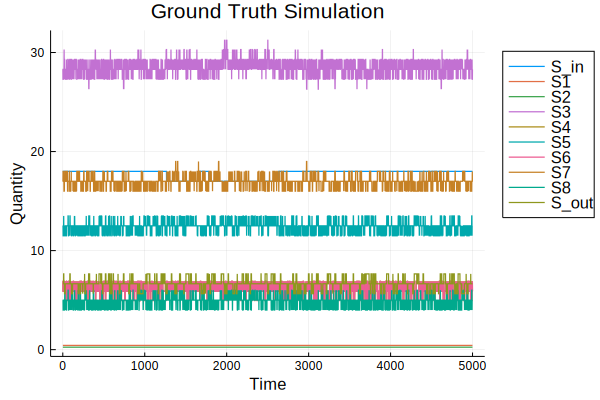

In [8]:
simple_sim = omega_simulation(theta, transition, starting_species, 5000, 02)
plot(hcat(simple_sim["S_in"], simple_sim["S1"], simple_sim["S2"], simple_sim["S3"], simple_sim["S4"], simple_sim["S5"],
        simple_sim["S6"], simple_sim["S7"], simple_sim["S8"], simple_sim["S_out"]),
        title = "Ground Truth Simulation",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["S_in" "S1" "S2" "S3" "S4" "S5" "S6" "S7" "S8" "S_out"],
        lw = 1.25,
        legend = :outertopright)

#### Counterfactual

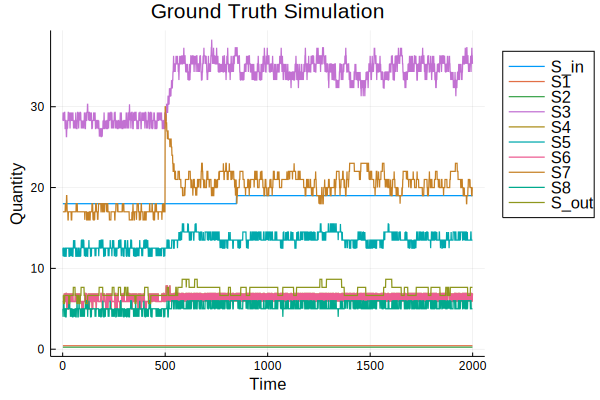

In [9]:
simple_sim = omega_simulation(theta, transition, starting_species, 2000, 50, ("S7", 500, 30.))
plot(hcat(simple_sim["S_in"], simple_sim["S1"], simple_sim["S2"], simple_sim["S3"], simple_sim["S4"], simple_sim["S5"],
        simple_sim["S6"], simple_sim["S7"], simple_sim["S8"], simple_sim["S_out"]),
        title = "Ground Truth Simulation",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["S_in" "S1" "S2" "S3" "S4" "S5" "S6" "S7" "S8" "S_out"],
        lw = 1.25,
        legend = :outertopright)

### Gillespie Simulation (No Omega)

In [10]:
## Define Functions
function gillespie(transitions, initial, N, seed)

    trajectory = OrderedDict("S_in" => [initial["S_in"]], "S1" => [initial["S1"]], "S2" => [initial["S2"]], 
        "S3" => [initial["S3"]], "S4" => [initial["S4"]],"S5" => [initial["S5"]], "S6" => [initial["S6"]], 
        "S7" => [initial["S7"]], "S8" => [initial["S8"]], "S_out" => [initial["S_out"]])
    ecology = copy(initial)
    
    ## Rates (used vals specified in SBML)
    kf_J1 = 0.31; kr_J1 = 0.39; K1_J1 = 0.64; K2_J1 = 0.76 #reaction1
    kf_J2 = 0.79; kr_J2 = 0.27; K1_J2 = 0.41; K2_J2 = 0.19 #reaction2
    kf_J3 = 0.55; kr_J3 = 0.40; K1_J3 = 0.26; K2_J3 = 0.38 #reaction3
    kf_J4 = 0.74; kr_J4 = 0.34 #reaction4
    kf_J5 = 0.83; kr_J5 = 0.40 #reaction5
    kf_J6 = 0.67; kr_J6 = 0.83 #reaction6

    theta =  Dict("kf_J1" => kf_J1, "kr_J1" => kr_J1, "K1_J1" => K1_J1, "K2_J1" => K2_J1,
             "kf_J2" => kf_J2, "kr_J2" => kr_J2, "K1_J2" => K1_J2, "K2_J2" => K2_J2,
             "kf_J3" => kf_J3, "kr_J3" => kr_J3, "K1_J3" => K1_J3, "K2_J3" => K2_J3,
             "kf_J4" => kf_J4, "kr_J4" => kr_J4,
             "kf_J5" => kf_J5, "kr_J5" => kr_J5,
             "kf_J6" => kf_J6, "kr_J6" => kr_J6)
    Random.seed!(seed)
    for i = 1:N
        
        hazards = get_hazards(ecology, theta)
        update_t = deepcopy(transitions)
        
        for (key, value) in hazards
            if value < 0
                hazards[key] = 0 - value
                for idx in 1:length(update_t[key])
                    update_t[key][idx] = 0 - update_t[key][idx]
                end
            end
        end

        t = update_t[sample(collect(keys(hazards)), Weights(collect(values(hazards))))]

        ecology["S_in"] += t[1]
        ecology["S1"] += t[2]
        ecology["S2"] += t[3]
        ecology["S3"] += t[4]
        ecology["S4"] += t[5]
        ecology["S5"] += t[6]
        ecology["S6"] += t[7]
        ecology["S7"] += t[8]
        ecology["S8"] += t[9]
        ecology["S_out"] += t[10]
        
        # Enforce only positive integers
        ecology["S_in"] = max(0, ecology["S_in"])
        ecology["S3"] = max(0, ecology["S3"])
        ecology["S4"] = max(0, ecology["S4"])
        ecology["S5"] = max(0, ecology["S5"])
        ecology["S6"] = max(0, ecology["S6"])
        ecology["S7"] = max(0, ecology["S7"])
        ecology["S8"] = max(0, ecology["S8"])
        ecology["S_out"] = max(0, ecology["S_out"])

        push!(trajectory["S_in"], ecology["S_in"])
        push!(trajectory["S1"], ecology["S1"])
        push!(trajectory["S2"], ecology["S2"])
        push!(trajectory["S3"], ecology["S3"])
        push!(trajectory["S4"], ecology["S4"])
        push!(trajectory["S5"], ecology["S5"])
        push!(trajectory["S6"], ecology["S6"])
        push!(trajectory["S7"], ecology["S7"])
        push!(trajectory["S8"], ecology["S8"])
        push!(trajectory["S_out"], ecology["S_out"])
    end

    return trajectory
end

function get_hazards(ecology, theta)
    return OrderedDict(
        "S_in_to_S7" => ecology["S2"]*((theta["kf_J1"]*ecology["S_in"]/theta["K1_J1"] - theta["kr_J1"]*ecology["S7"]/theta["K2_J1"]
            )/(1 + ecology["S_in"]/theta["K1_J1"] + ecology["S7"]/theta["K2_J1"])),
        "S8_to_S_out" => ecology["S5"]*((theta["kf_J2"]*ecology["S8"]/theta["K1_J2"] - theta["kr_J2"]*ecology["S_out"]/theta["K2_J2"]
            )/(1 + ecology["S8"]/theta["K1_J2"] + ecology["S_out"]/theta["K2_J2"])),
        "S_out_to_S8" => ecology["S1"]*((theta["kf_J3"]*ecology["S_out"]/theta["K2_J3"] - theta["kr_J3"]*ecology["S8"]/theta["K1_J3"]
            )/(1 + ecology["S_out"]/theta["K2_J3"] + ecology["S8"]/theta["K1_J3"])),
        "S3_to_S8_and_S5" => theta["kf_J4"]*ecology["S3"] - theta["kr_J4"]*ecology["S8"]*ecology["S5"],
        "S7_to_S6_and_S4" => theta["kf_J5"]*ecology["S7"] - theta["kr_J5"]*ecology["S6"]*ecology["S4"],
        "S4_and_S6_to_S3" => theta["kf_J6"]*ecology["S4"]*ecology["S6"] - theta["kr_J6"]*ecology["S3"]
        )
end


get_hazards (generic function with 1 method)

In [11]:
t = OrderedDict("S_in_to_S7" => transition[1],
        "S8_to_S_out" => transition[2],
        "S_out_to_S8" => transition[3],
        "S3_to_S8_and_S5" => transition[4],
        "S7_to_S6_and_S4" => transition[5],
        "S4_and_S6_to_S3" => transition[6])

OrderedDict{String,Array{Int64,1}} with 6 entries:
  "S_in_to_S7"      => [-1, 0, 0, 0, 0, 0, 0, 1, 0, 0]
  "S8_to_S_out"     => [0, 0, 0, 0, 0, 0, 0, 0, -1, 1]
  "S_out_to_S8"     => [0, 0, 0, 0, 0, 0, 0, 0, 1, -1]
  "S3_to_S8_and_S5" => [0, 0, 0, -1, 0, 1, 0, 0, 1, 0]
  "S7_to_S6_and_S4" => [0, 0, 0, 0, 1, 0, 1, -1, 0, 0]
  "S4_and_S6_to_S3" => [0, 0, 0, 1, -1, 0, -1, 0, 0, 0]

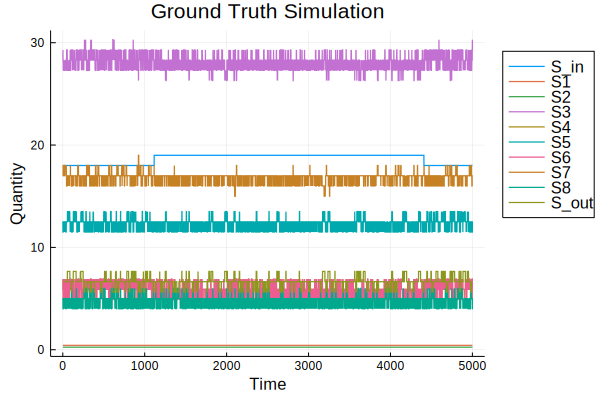

In [13]:
non_omega_sim = gillespie(t, starting_species, 5000, 12)
plot(hcat(non_omega_sim["S_in"], non_omega_sim["S1"], non_omega_sim["S2"], non_omega_sim["S3"], non_omega_sim["S4"], non_omega_sim["S5"],
        non_omega_sim["S6"], non_omega_sim["S7"], non_omega_sim["S8"], non_omega_sim["S_out"]),
        title = "Ground Truth Simulation",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["S_in" "S1" "S2" "S3" "S4" "S5" "S6" "S7" "S8" "S_out"],
        lw = 1.25,
        legend = :outertopright)

### Target Enzymes

In this model S1 and S2 are enzymes. Which are used in the following two rates:

S1: S_out <=> S8;  $S1*\frac{(kf_{J3}*S_{out}/K2_{J3})}{(1 + S_{out}/K2_{J3})}$

S2: S_in <=> S7; $S2*\frac{(kf_{J1}*S_{in}/K1_{J1})}{(1 + S_{in}/K1_{J1})}$

### Steady State

#### Set S2 = 0 at Time = 500

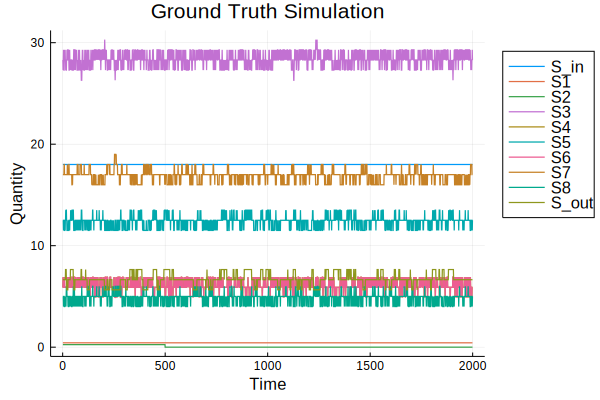

In [14]:
simple_sim = omega_simulation(theta, transition, starting_species, 2000, 50, ("S2", 500, 0.))
plot(hcat(simple_sim["S_in"], simple_sim["S1"], simple_sim["S2"], simple_sim["S3"], simple_sim["S4"], simple_sim["S5"],
        simple_sim["S6"], simple_sim["S7"], simple_sim["S8"], simple_sim["S_out"]),
        title = "Ground Truth Simulation",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["S_in" "S1" "S2" "S3" "S4" "S5" "S6" "S7" "S8" "S_out"],
        lw = 1.25,
        legend = :outertopright)

#### S2 = 1

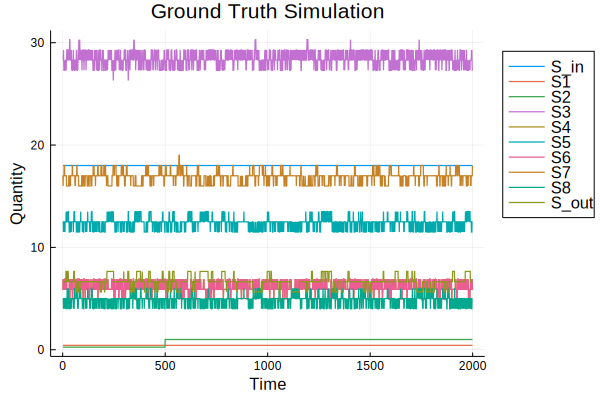

In [15]:
simple_sim = omega_simulation(theta, transition, starting_species, 2000, 50, ("S2", 500, 1.))
plot(hcat(simple_sim["S_in"], simple_sim["S1"], simple_sim["S2"], simple_sim["S3"], simple_sim["S4"], simple_sim["S5"],
        simple_sim["S6"], simple_sim["S7"], simple_sim["S8"], simple_sim["S_out"]),
        title = "Ground Truth Simulation",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["S_in" "S1" "S2" "S3" "S4" "S5" "S6" "S7" "S8" "S_out"],
        lw = 1.25,
        legend = :outertopright)

#### S2 = 20

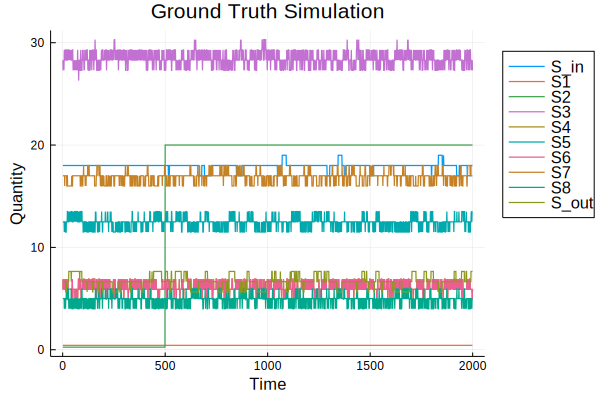

In [16]:
simple_sim = omega_simulation(theta, transition, starting_species, 2000, 50, ("S2", 500, 20.))
plot(hcat(simple_sim["S_in"], simple_sim["S1"], simple_sim["S2"], simple_sim["S3"], simple_sim["S4"], simple_sim["S5"],
        simple_sim["S6"], simple_sim["S7"], simple_sim["S8"], simple_sim["S_out"]),
        title = "Ground Truth Simulation",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["S_in" "S1" "S2" "S3" "S4" "S5" "S6" "S7" "S8" "S_out"],
        lw = 1.25,
        legend = :outertopright)

### Adjust to Non-steady State

#### Increase S_in to 30

In [17]:
non_steady_species = OrderedDict("S_in" => 30., "S1" => .43, "S2" => .25, 
    "S3" => 28.3, "S4" => 5.9, "S5" => 12.5, "S6" => 5.9, "S7" => 17.,
    "S8" => 5., "S_out" => 6.65)

OrderedDict{String,Float64} with 10 entries:
  "S_in"  => 30.0
  "S1"    => 0.43
  "S2"    => 0.25
  "S3"    => 28.3
  "S4"    => 5.9
  "S5"    => 12.5
  "S6"    => 5.9
  "S7"    => 17.0
  "S8"    => 5.0
  "S_out" => 6.65

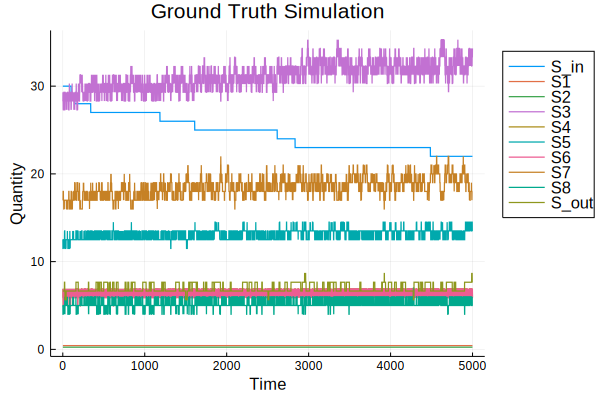

In [24]:
simple_sim = omega_simulation(theta, transition, non_steady_species, 5000, 50)
plot(hcat(simple_sim["S_in"], simple_sim["S1"], simple_sim["S2"], simple_sim["S3"], simple_sim["S4"], simple_sim["S5"],
        simple_sim["S6"], simple_sim["S7"], simple_sim["S8"], simple_sim["S_out"]),
        title = "Ground Truth Simulation",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["S_in" "S1" "S2" "S3" "S4" "S5" "S6" "S7" "S8" "S_out"],
        lw = 1.25,
        legend = :outertopright)

S3 and S7 move up to higher steady state and show much more volatility. S_in moves down but does not reach its old steady state.

#### S2 = 0

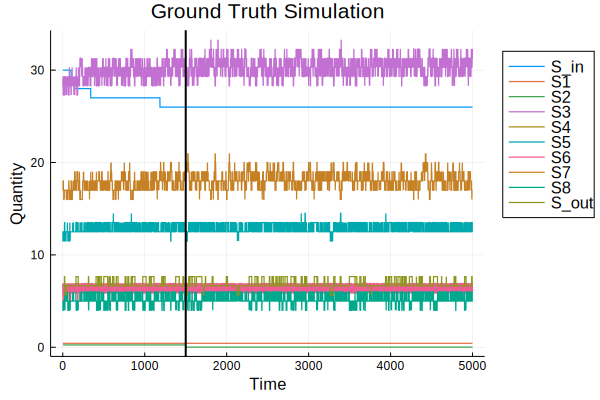

In [25]:
simple_sim = omega_simulation(theta, transition, non_steady_species, 5000, 50, ("S2", 1500, .01))
plot(hcat(simple_sim["S_in"], simple_sim["S1"], simple_sim["S2"], simple_sim["S3"], simple_sim["S4"], simple_sim["S5"],
        simple_sim["S6"], simple_sim["S7"], simple_sim["S8"], simple_sim["S_out"]),
        title = "Ground Truth Simulation",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["S_in" "S1" "S2" "S3" "S4" "S5" "S6" "S7" "S8" "S_out"],
        lw = 1.25,
        legend = :outertopright)
plot!([1500], seriestype="vline", color = "black", lw = 2, label = false)

When adjusting enzyme down, the reaction stops at a new steady state early.

#### S2 = 1

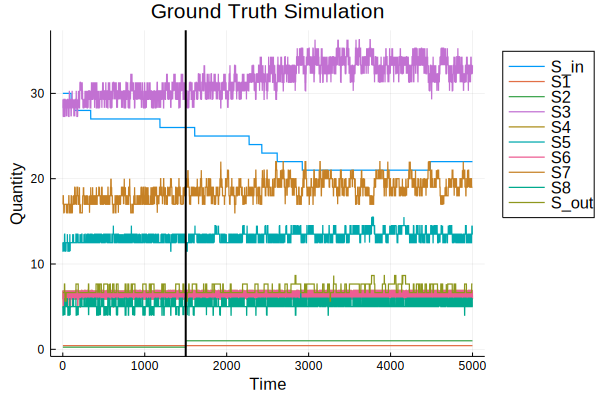

In [26]:
simple_sim = omega_simulation(theta, transition, non_steady_species, 5000, 50, ("S2", 1500, 1))
plot(hcat(simple_sim["S_in"], simple_sim["S1"], simple_sim["S2"], simple_sim["S3"], simple_sim["S4"], simple_sim["S5"],
        simple_sim["S6"], simple_sim["S7"], simple_sim["S8"], simple_sim["S_out"]),
        title = "Ground Truth Simulation",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["S_in" "S1" "S2" "S3" "S4" "S5" "S6" "S7" "S8" "S_out"],
        lw = 1.25,
        legend = :outertopright)
plot!([1500], seriestype="vline", color = "black", lw = 2, label = false)

With a high enzyme adjust, the reaction accelerates to a new steady state much faster.

### What advantage does Causal Inference give us?

Lets say we are interested in the relationship between S3, and the S2 enzyme at these new starting species values.

First we can run a couple counterfactual simulations and see what the general effect of S1 on S8 is.

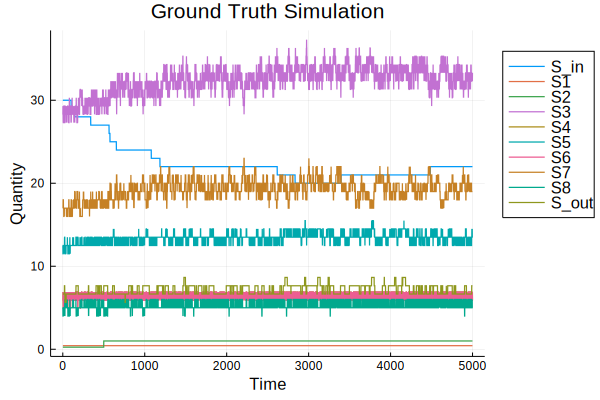

In [27]:
simple_sim = omega_simulation(theta, transition, non_steady_species, 5000, 50, ("S2", 500, 1))
plot(hcat(simple_sim["S_in"], simple_sim["S1"], simple_sim["S2"], simple_sim["S3"], simple_sim["S4"], simple_sim["S5"],
        simple_sim["S6"], simple_sim["S7"], simple_sim["S8"], simple_sim["S_out"]),
        title = "Ground Truth Simulation",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["S_in" "S1" "S2" "S3" "S4" "S5" "S6" "S7" "S8" "S_out"],
        lw = 1.25,
        legend = :outertopright)

In [30]:
effect_list = []
for x in 1:200
    rand_seed = rand(1:1000000)
    simple_sim = omega_simulation(theta, transition, non_steady_species, 3000, rand_seed, ("S2", 500, 1))
    effect_S3 = simple_sim["S3"][2999]
    push!(effect_list, effect_S3)
end

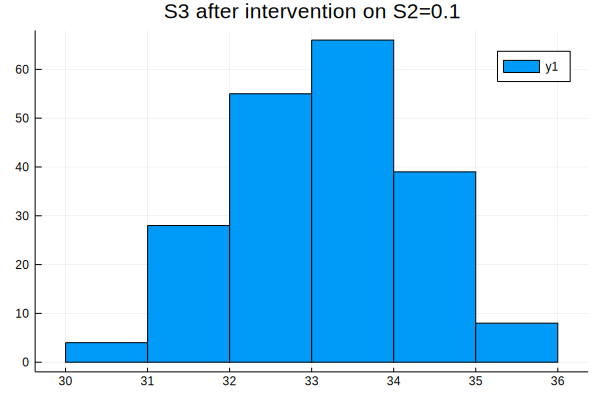

In [31]:
histogram(effect_list, bins = 8, title = "S3 after intervention on S2=0.1")

Now lets see what happens after 1500 time points of a normal sim

In [32]:
starting_species_normal_sim = OrderedDict("S_in" => 30., "S1" => .4, "S2" => 1., 
    "S3" => 28.3, "S4" => 5.9, "S5" => 12.5, "S6" => 5.9, "S7" => 17.,
    "S8" => 5., "S_out" => 6.65)

OrderedDict{String,Float64} with 10 entries:
  "S_in"  => 30.0
  "S1"    => 0.4
  "S2"    => 1.0
  "S3"    => 28.3
  "S4"    => 5.9
  "S5"    => 12.5
  "S6"    => 5.9
  "S7"    => 17.0
  "S8"    => 5.0
  "S_out" => 6.65

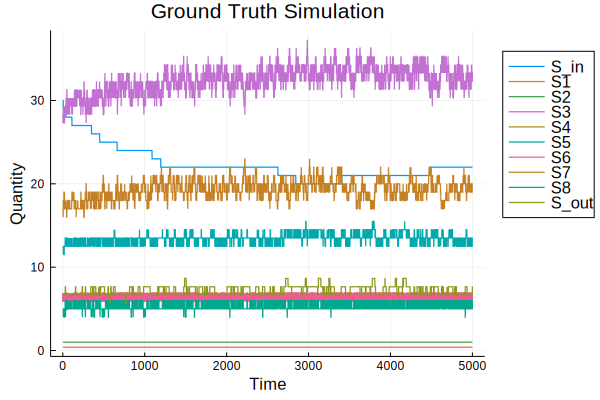

In [34]:
non_omega_sim = gillespie(t, starting_species_normal_sim, 5000, 50)
plot(hcat(non_omega_sim["S_in"], non_omega_sim["S1"], non_omega_sim["S2"], non_omega_sim["S3"], non_omega_sim["S4"], non_omega_sim["S5"],
        non_omega_sim["S6"], non_omega_sim["S7"], non_omega_sim["S8"], non_omega_sim["S_out"]),
        title = "Ground Truth Simulation",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["S_in" "S1" "S2" "S3" "S4" "S5" "S6" "S7" "S8" "S_out"],
        lw = 1.25,
        legend = :outertopright)

In [35]:
effect_list_normal_sim = []
for x in 1:200
    rand_seed = rand(1:100000000)
    non_omega_sim = gillespie(t, starting_species_normal_sim, 3000, rand_seed)
    effect_S3 = non_omega_sim["S3"][3000]
    push!(effect_list_normal_sim, effect_S3)
end

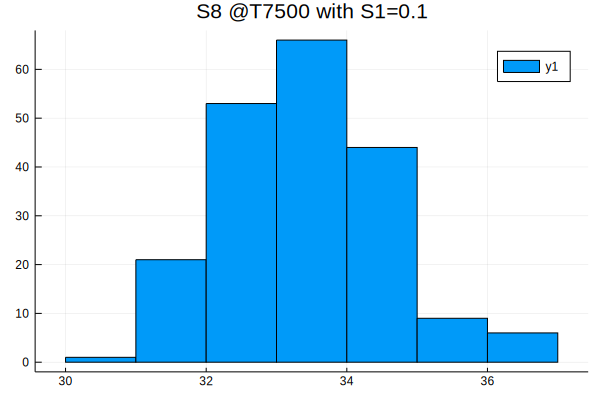

In [36]:
histogram(effect_list_normal_sim, bins = 10, title = "S8 @T7500 with S1=0.1")

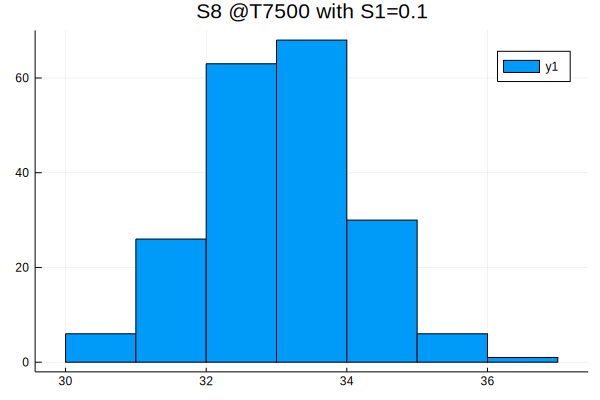

In [37]:
effect_list_normal_sim = []
for x in 1:200
    rand_seed = rand(1:100000000)
    non_omega_sim = gillespie(t, non_steady_species, 3000, rand_seed)
    
    intervention_sim = OrderedDict("S_in" => non_omega_sim["S_in"][500], "S1" => non_omega_sim["S1"][500], "S2" => 1., 
        "S3" => non_omega_sim["S3"][500], "S4" => non_omega_sim["S4"][500], "S5" => non_omega_sim["S5"][500], 
        "S6" => non_omega_sim["S6"][500], "S7" => non_omega_sim["S7"][500], "S8" => non_omega_sim["S8"][500], 
        "S_out" => non_omega_sim["S_out"][500])
    
    non_omega_sim_int = gillespie(t, intervention_sim, 3000, rand_seed)
    effect_S3 = non_omega_sim_int["S3"][2500]
    push!(effect_list_normal_sim, effect_S3)
end

histogram(effect_list_normal_sim, bins = 10, title = "S8 @T7500 with S1=0.1")

In [40]:
moving_average(vs,n) = [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]

moving_average (generic function with 1 method)

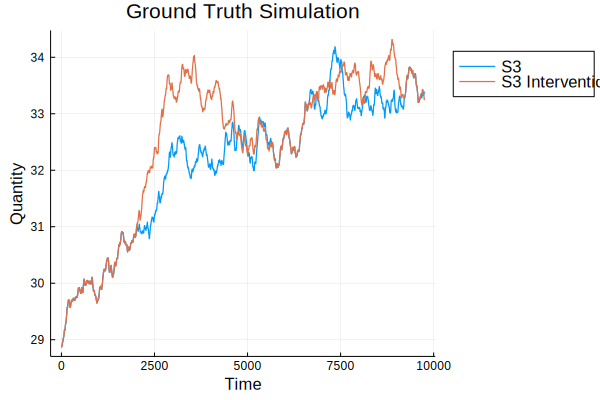

In [57]:
simple_sim = omega_simulation(theta, transition, non_steady_species, 10000, 50)
simple_sim_int = omega_simulation(theta, transition, non_steady_species, 10000, 50, ("S2", 2000, 1))
plot(hcat(moving_average(simple_sim["S3"], 250), moving_average(simple_sim_int["S3"], 250)),
        title = "Ground Truth Simulation",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["S3" "S3 Intervention"],
        lw = 1.25,
        legend = :outertopright)

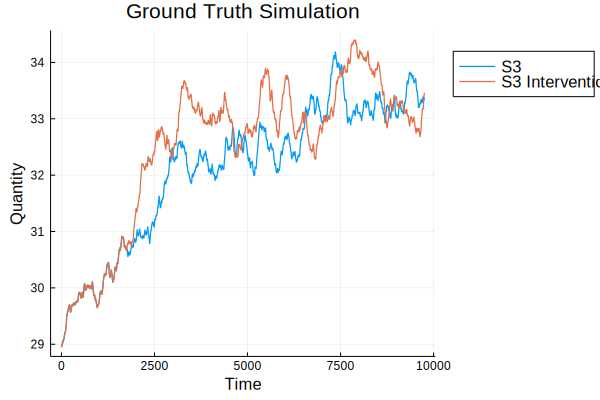

In [58]:
rand_seed = 50
non_omega_sim = gillespie(t, non_steady_species, 10000, rand_seed)

intervention_sim = OrderedDict("S_in" => non_omega_sim["S_in"][2000], "S1" => non_omega_sim["S1"][2000], "S2" => 1., 
    "S3" => non_omega_sim["S3"][2000], "S4" => non_omega_sim["S4"][2000], "S5" => non_omega_sim["S5"][2000], 
    "S6" => non_omega_sim["S6"][2000], "S7" => non_omega_sim["S7"][2000], "S8" => non_omega_sim["S8"][2000], 
    "S_out" => non_omega_sim["S_out"][2000])

non_omega_sim_int = gillespie(t, intervention_sim, 8000, rand_seed)
plot(hcat(moving_average(non_omega_sim["S3"], 250),
        moving_average(vcat(non_omega_sim["S3"][1:2000], non_omega_sim_int["S3"]), 250)),
        title = "Ground Truth Simulation",
        xlabel = "Time",
        ylabel = "Quantity",
        label = ["S3" "S3 Intervention"],
        lw = 1.25,
        legend = :outertopright)

### Abduction-action-prediction

In this section we will infer traces which satisfy the below formula, indicating a system at steady state. We will then sample from these traces, apply a counterfactual, and compile the results to a histogram to make a prediction.

$$P(N_{Species} | Species_{T5000} = \text{Steady State})$$

$$Steady State = \{ S_{in} = 18, S1 = .43, S2 = .25,
    S3 = 28, S4 = 6, S5 = 13, S6 = 6, S7 = 17,
    S8 = 5, S_{out} = 7 \}$$
    
** Rounded to whole numbers for easy processing

In [64]:
starting_species

OrderedDict{String,Float64} with 10 entries:
  "S_in"  => 18.0
  "S1"    => 0.43
  "S2"    => 0.25
  "S3"    => 28.3
  "S4"    => 5.9
  "S5"    => 12.5
  "S6"    => 5.9
  "S7"    => 17.0
  "S8"    => 5.0
  "S_out" => 6.65

In [ ]:
non_omega_sim = gillespie(t, starting_species, 10000, rand_seed, conditional = )